In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
%matplotlib inline
import scipy.stats as sp
import matplotlib as mtp
#import PQ3_preprocessing as PQ3
mtp.rcParams['pdf.fonttype'] = 42

In [4]:
tcgaDf = pd.read_csv("C:/Data/Lab/Carter_Lab/aneuploidy_data/TCGA_TP_allgene.csv")
scnaDf = pd.read_csv("C:/Data/Lab/Carter_Lab/aneuploidy_data/SCNADf_v3.tsv",sep ="\t")

In [5]:
cd4 = ["CD3D","CD3E","CD3G","CD4"]
cd8 = ["CD3D","CD3E","CD3G","CD8A","CD8B"]
bcell = ["CD19","MS4A1"]
cd3 = ["CD3D","CD3E","CD3G"]

# Figure 4

### panel A

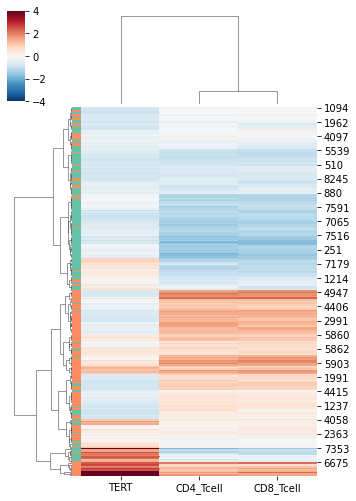

In [24]:
import warnings
warnings.filterwarnings('ignore')

### panel A
hnsc = tcgaDf[tcgaDf.disease == "HNSC"]

b_exp = sp.stats.gmean(np.log2(1+hnsc[bcell]),axis=1)
b_cat = pd.cut(x = b_exp, bins = [-np.inf,np.quantile(b_exp,q=.3),np.quantile(b_exp,q=.7),np.inf],labels=["LOW","MID","HIGH"])

tert_exp = np.log2(1+hnsc["TERT"]).values
tert_cat = pd.cut(x = tert_exp, bins = [-np.inf,np.quantile(tert_exp,q=.3),np.quantile(tert_exp,q=.7),np.inf],labels=["LOW","MID","HIGH"])

hnsc["Bcell_cat"] = b_cat
hnsc["CD4_Tcell"] = sp.stats.gmean(np.log2(1 + hnsc[cd4]),axis=1)
hnsc["CD8_Tcell"] = sp.stats.gmean(np.log2(1 + hnsc[cd8]),axis=1)
hnsc["TERT"] = np.log2(1+hnsc["TERT"])

subdf = hnsc[hnsc["Bcell_cat"] != "MID"]
#colordict = sns.color_palette("Set2")[:2]
colormap = dict(zip(["LOW","HIGH"],sns.color_palette("Set2")[:2]))
sns.clustermap(subdf[["TERT","CD4_Tcell","CD8_Tcell"]].apply(sp.stats.zscore),
               cmap = "RdBu_r",
               center = 0,
               vmax = 4,
               vmin = -4,
               method= 'ward',
               figsize = (5,7),
               row_colors=[ colormap[x] for x in subdf["Bcell_cat"]])
#plt.savefig(DIR+"fig3c.heatmap_bcell_low_and_high.pdf", bbox_inches = "tight")

### Panel B

<AxesSubplot:xlabel='index', ylabel='value'>

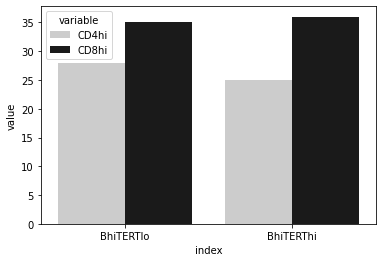

In [25]:
dfplot = pd.DataFrame(index = ["BhiTERTlo","BhiTERThi"], columns = ["CD4hi","CD8hi"],
                      data = np.array([[28,35],[25,36]]))
dfplot = pd.melt(dfplot.reset_index(), id_vars=["index"])

CMAP_GRAY = [(0.8,0.8,0.8),
             (0.1,0.1,0.1)] # The Gray and Black cmap
CMAP_WHITE = [(0.95,0.95,0.95),
             (0.6,0.6,0.6)]
CMAP_WHITE_R = [(0.6,0.6,0.6),
               (0.95,0.95,0.95)]

sns.barplot(x = "index", y = "value", hue = "variable", data = dfplot, palette = CMAP_GRAY)
#plt.savefig(DIR + "fig3.frequencyplot.pdf",bbox_inches = "tight")

In [62]:
pd.DataFrame(index = ["BhiTERTlo","BhiTERThi"], columns = ["CD4hi","CD8hi"],
                      data = np.array([[28,35],[25,36]]))

,CD4hi,CD8hi
BhiTERTlo,28,35
BhiTERThi,25,36


In [26]:
sp.stats.fisher_exact([[28,35],[25,36]])

(1.152, 0.7199571000598064)

### Panel C

In [56]:
lm22 = pd.read_csv("C:/Data/Lab/Zanetti_Lab/LM22.txt",sep = "\t",index_col=0)

tfh_sig_natcom = ["CXCR5","ICOS","CD40LG","PDCD1","CXCL13"]
# https://www.nature.com/articles/s41467-021-23355-x#Sec9 Nature

tls_sig = lm22["T cells follicular helper"].sort_values(ascending = False)[:21].index.tolist()
tls_sig_cibersort = set(hnsc.columns).intersection(tls_sig)

low_ids = hnsc[(b_cat == "HIGH") & (tert_cat == "LOW")]["patient_id"].tolist()
high_ids = hnsc[(b_cat == "HIGH") & (tert_cat == "HIGH")]["patient_id"].tolist()
#other_ids = hnsc[(b_cat != "HIGH") & (tert_cat != "HIGH")]["patient_id"].tolist()

# cytokines
tls_cyto = ["CCL2","CCL3","CCL4","CCL5","CCL8","CCL18","CCL19","CCL21","CXCL9","CXCL10","CXCL11","CXCL13"]
# in breast cancer
# https://www.nature.com/articles/s41568-019-0144-6
tfh_genes = ["CXCL13","CD200","FBLN7","ICOS","SGPP2","SH2D1A","TIGIT","PDCD1"]
# in gastric cancer
# https://www.nature.com/articles/s41568-019-0144-6
th1_bcell = ["CD4","CCR5","CXCR3","CSF2","IGSF6","IL2RA","CD38","CD40","CD5","MS4A1"]

i = 0
genesets = set(tfh_sig_natcom).union(tls_sig_cibersort).union(tfh_genes).union(th1_bcell)
genesets = set(hnsc.columns).intersection(genesets)
df = pd.DataFrame(index = genesets)
df_pval = pd.DataFrame(index = genesets)

for geneset in [tfh_sig_natcom, tls_sig_cibersort, tfh_genes, th1_bcell, tls_cyto]:
    dif_dict = {}
    print(len(geneset))
    for gene in geneset:
        if gene in genesets:
            dif_dict[gene] = sp.stats.ttest_ind(hnsc.set_index("patient_id").loc[high_ids][gene],
                              hnsc.set_index("patient_id").loc[low_ids][gene])
    #print(len(genesets))
    df[i] = pd.Series(index = dif_dict.keys(), data = [dif_dict[x][0] for x in dif_dict.keys()])
    df_pval[i] = pd.Series(index = dif_dict.keys(), data = [dif_dict[x][1] for x in dif_dict.keys()])
    i += 1


5
20
8
10
12


RanksumsResult(statistic=1.3619017058645857, pvalue=0.17322890777813715)
RanksumsResult(statistic=1.4238063288584306, pvalue=0.15450254314588055)
RanksumsResult(statistic=1.3851159394872776, pvalue=0.1660170187474953)
RanksumsResult(statistic=0.4720227503280666, pvalue=0.6369105499939176)
RanksumsResult(statistic=0.27083272559807103, pvalue=0.7865196888022692)


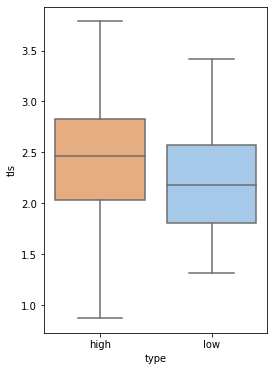

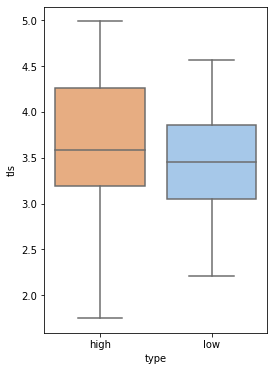

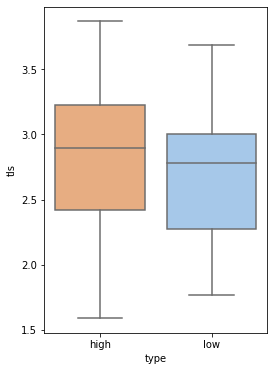

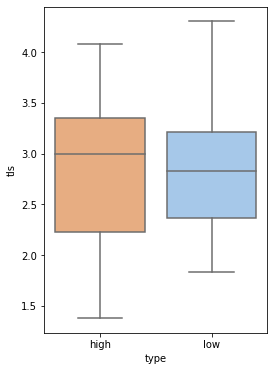

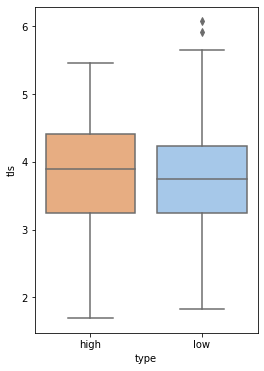

In [33]:
i = 0
for geneset in [tfh_sig_natcom, tls_sig_cibersort, tfh_genes, th1_bcell, tls_cyto]:
    _high_tls = np.mean(np.log2(1+hnsc.set_index("patient_id").loc[high_ids][geneset]),axis=1)
    _low_tls = np.mean(np.log2(1+hnsc.set_index("patient_id").loc[low_ids][geneset]),axis=1)
    print(sp.stats.ranksums(_high_tls,
                            _low_tls))

    dfplot = pd.DataFrame({"tls":list(_high_tls) + list(_low_tls),
                           "type":["high"] * len(_high_tls) + ["low"] * len(_low_tls)})
    plt.figure(figsize = (4,6))
    sns.boxplot(x = "type",y = "tls", data = dfplot, 
                #palette = "pastel", 
                palette = {"high":"#F8AA71",
                           "low":"#9BC8F4"},
                order = ["high","low"])
    
    #plt.savefig(save_dir + "fig4_E_"+str(i)+"+.pdf",bbox_inches = "tight")
    i += 1

### Panel D

In [36]:
low_ids = hnsc[(b_cat == "HIGH") & (tert_cat == "LOW")]["patient_id"].tolist()
high_ids = hnsc[(b_cat == "HIGH") & (tert_cat == "HIGH")]["patient_id"].tolist()

df_gsea = hnsc.set_index("patient_id").loc[low_ids + high_ids]

df_gsea = df_gsea.drop(["Unnamed: 0"],axis=1).T
genelist = df_gsea.index.tolist()
df_gsea.reset_index(inplace = True)
df_gsea["DESCRIPTION"] = "na"
df_gsea.rename(columns = {"index":"NAME"}, inplace = True)
df_gsea = df_gsea[["NAME","DESCRIPTION"] + low_ids + high_ids]
df_gsea = df_gsea.iloc[:-5]
#df_gsea.iloc[:,2:] = np.log2(1+df_gsea.iloc[:,2:].astype(float))

tmp = pd.merge(df_gsea[["NAME","DESCRIPTION"]].reset_index(),df_gsea[high_ids + low_ids].apply(pd.to_numeric).reset_index(), on = "index").set_index("index")

cls = ["L" if x in set(low_ids) else "H" for x in tmp.columns.tolist()[2:]]
f_dir = "C:/Data/Lab/Zanetti_Lab/HNSC/"
geneset_dir = "C:/Data/Lab/Zanetti_Lab/msigDB/combined_v2.gmt"
#geneset_dir = "C:/Data/Lab/Zanetti_Lab/msigDB/GOBP/combined.gmt"
gs_res_v3 = gp.gsea(data = tmp[tmp.iloc[:,2:].mean(axis=1) >= .5], # remove low exp genes
             gene_sets = geneset_dir,
             cls = cls,
             permutation_type ='gene_set',
             permutation_num = 200, # reduce number to speed up test
             outdir = f_dir,  # do not write output to disk
             no_plot = True, # Skip plotting
             method='t_test',
             processes = 4, seed = 42, # was seed = 7
             format ='png'
                )

dfplot = gs_res_v3.res2d
dfplot["significance"] = [ x < .25 for x in dfplot["fdr"]]

sns.barplot(x = "nes", y = "Term", 
                data = dfplot.reset_index().sort_values(by ="nes",ascending = False),
                palette = "pastel",
#                 linewidth=2.5, facecolor=(1, 1, 1, 0),
#                 errcolor=".2", edgecolor=".2",
                hue = "significance", dodge=False,
                )
plt.axvline(x = 0,color = 'k')
#save_dir = "C:/Data/Lab/Zanetti_Lab/Figures/"
#plt.savefig(save_dir + "gsea_enrich_bcell_tcell.pdf",bbox_inches="tight")

NameError: name 'gp' is not defined

### Panel E

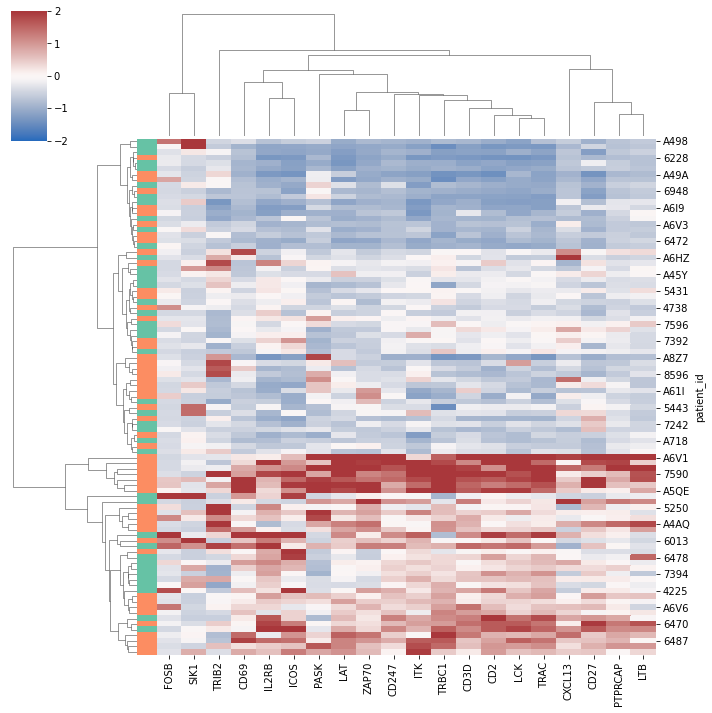

In [59]:
choice = sns.color_palette("Set2")
sns.clustermap(hnsc.set_index("patient_id").loc[high_ids + low_ids][tls_sig_cibersort].apply(sp.stats.zscore),
              center = 0,
              cmap = "vlag",
              vmax = 2,
              vmin = -2,
              method = "ward",
              #col_cluster= False,
              #figsize = (9,5),
              row_colors = [ choice[1] if x in set(high_ids) else choice[0] for x in high_ids + low_ids])
#plt.savefig(save_dir + "TLS_heatmap.pdf",bbox_inches = 'tight')

### Panel F

Text(0, 0.5, 'log2 expression TPM')

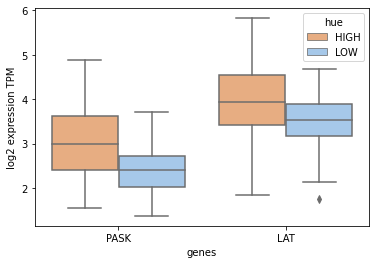

In [60]:
dfplot = np.log2(1+hnsc.set_index("patient_id").loc[high_ids + low_ids][["PASK","LAT"]]).reset_index()
dfplot["hue"] = ["LOW" if x in set(low_ids) else "HIGH" for x in dfplot["patient_id"]]
dfplot = dfplot.melt(id_vars = ["patient_id","hue"])

sns.boxplot(x = "variable", y = "value", hue = "hue", palette = {"HIGH":"#F8AA71",
                           "LOW":"#9BC8F4"},
            data = dfplot)
plt.xlabel("genes")
plt.ylabel("log2 expression TPM")
#save_dir = "C:/Data/Lab/Zanetti_Lab/Figures/"
#plt.savefig(save_dir + "tfh_genes_difexp.pdf",bbox_inches = "tight")

### Panel G-I

In [68]:
hnsc_cibersort = pd.read_csv("C:/Data/Lab/Zanetti_Lab/data/cibersort/HNSC.out.csv")
hnsc_cibersort.rename(columns = {"Input Sample":"patient_id"}, inplace =True)

hpv_neg_ids_cbioportal = pd.read_csv("C:/Data/Lab/Zanetti_Lab/HNSC/hnsc_tcga_pan_can_atlas_2018_clinical_data.tsv",sep = "\t")
hpv_pos_ids_cbioportal = [ x.split("-")[2] for x in hpv_neg_ids_cbioportal[hpv_neg_ids_cbioportal["Subtype"] == "HNSC_HPV+"]["Patient ID"].tolist()]

def colormap(idslist):
    mappings = []
    for ids in idslist:
        if ids in low_ids:
            mappings.append("#229954")
        elif ids in high_ids:
            mappings.append("#F1C40F")
        else:
            mappings.append("gray")
    return mappings

In [71]:
# MUC1
# Bhi Thi vs Blow Thi:
def plot_tfh_distribution(gene,savefig = False, hpv_negative_only = False):
    """requires global HNSC"""
    gene_exp = hnsc[gene].tolist()
    gene_cat = pd.cut(x = gene_exp,bins = [-np.inf,np.quantile(gene_exp,q=.3),np.quantile(gene_exp,q=.7),np.inf],labels=["LOW","MID","HIGH"])
    
    b_exp = sp.stats.gmean(np.log2(1+hnsc[bcell]),axis=1)
    b_cat = pd.cut(x = b_exp,bins = [-np.inf,np.quantile(b_exp,q=.3),np.quantile(b_exp,q=.7),np.inf],labels=["LOW","MID","HIGH"])

    
    low_ids = hnsc[(b_cat == "HIGH") & (gene_cat == "LOW")]["patient_id"].tolist()
    high_ids = hnsc[(b_cat == "HIGH") & (gene_cat == "HIGH")]["patient_id"].tolist()
    
    idx = list(set(hnsc_cibersort["patient_id"]).intersection(hnsc["patient_id"]))
    low_ids = list(set(low_ids).intersection(idx))
    high_ids = list(set(high_ids).intersection(idx))

    dfplot = pd.DataFrame({"tfh":hnsc_cibersort.set_index("patient_id").loc[low_ids+high_ids]["T cells follicular helper"],
                           "pid":["bhigh/tlow"] * len(low_ids) + ["bhigh/thigh"]*len(high_ids)})

    #sns.swarmplot(x = "pid",y = "scna",data=dfplot,palette = "Set2")
#     plt.figure(figsize = (3,4))
#     sns.boxplot(x = "pid",y = "tfh",
#                 data = dfplot,
#                 palette = "Set2")
#     plt.title("cibersort")
#     #plt.savefig(save_dir + "bhigh_terthigh_vs_bhigh_tertlow.pdf",bbox_inches="tight")

#     print(sp.stats.ttest_ind(dfplot[dfplot["pid"] == "bhigh/tlow"]["tfh"].tolist(),
#                      dfplot[dfplot["pid"] == "bhigh/thigh"]["tfh"].tolist()))

    figure, axes = plt.subplots(1, 2, sharey = True,
                                figsize=(7, 5),gridspec_kw={'width_ratios': [3, .7]})

    figure.tight_layout()
    
    if hpv_negative_only:
        idx = list(set(hnsc_cibersort["patient_id"]).intersection(hnsc["patient_id"]).difference(hpv_pos_ids_cbioportal))
    else:
        idx = list(set(hnsc_cibersort["patient_id"]).intersection(hnsc["patient_id"]))
    #v1 = np.mean(np.log2(1+hnsc.set_index("patient_id").loc[idx][tfh_genes]),axis=1)
    v2 = sp.stats.gmean(np.log2(1+hnsc.set_index("patient_id").loc[idx][bcell]),axis=1)
    
    def colormap(idslist):
        mappings = []
        for ids in idslist:
            if ids in low_ids:
                mappings.append("#229954")
            elif ids in high_ids:
                mappings.append("#F1C40F")
            else:
                mappings.append("gray")
        return mappings

    dfplot = pd.DataFrame({"Bcell signature":v2,
                           "T cells follicular helper %":hnsc_cibersort.set_index("patient_id").loc[idx]["T cells follicular helper"],
                           "hue":colormap(idx)})

    # axes 1
    sns.kdeplot(dfplot[dfplot["hue"] == "#F1C40F"]["T cells follicular helper %"],color = "#F1C40F",vertical = True, ax= axes[1], label = "bhigh/thigh")
    sns.kdeplot(dfplot[dfplot["hue"] == "#229954"]["T cells follicular helper %"],color = "#229954",vertical = True,ax = axes[1], label = "bhigh/tlow")

    # axes 0

    axes[0].scatter(v2,hnsc_cibersort.set_index("patient_id").loc[idx]["T cells follicular helper"],c = colormap(idx))
    #plt.subplot(Grid_plot[1, :2],)
    #plt.subplot(Grid_plot[1, 2])
    axes[0].set_ylim([-0.01,0.3])
    axes[1].legend()
    
    if savefig:
        save_dir = "C:/Data/Lab/Zanetti_Lab/Figures/finalize/Figure4/"
        if hpv_negative_only:
            plt.savefig(save_dir + gene +"_tls_bcell_hpv_neg.pdf",bbox_inches="tight")
        else:
            plt.savefig(save_dir + gene +"_tls_bcell.pdf",bbox_inches="tight")

    print(sp.stats.spearmanr(dfplot["Bcell signature"],
                       dfplot["T cells follicular helper %"]))

#F1C40F
    print(sp.stats.ttest_ind(dfplot[dfplot["hue"] == "#F1C40F"]["T cells follicular helper %"].tolist(),
                     dfplot[dfplot["hue"] == "#229954"]["T cells follicular helper %"].tolist()))

SpearmanrResult(correlation=0.3431651789447391, pvalue=1.241382241533238e-13)
Ttest_indResult(statistic=5.2937924763726425, pvalue=9.614234909255445e-07)


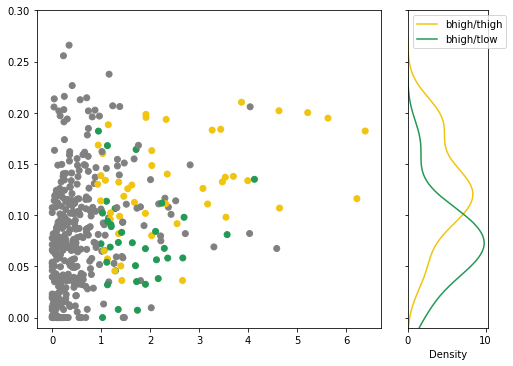

In [72]:
# G
plot_tfh_distribution("TERT",savefig = False, hpv_negative_only = False)

SpearmanrResult(correlation=0.26673671655072967, pvalue=1.5765377296984892e-07)
Ttest_indResult(statistic=4.333290193643119, pvalue=6.584559074051486e-05)


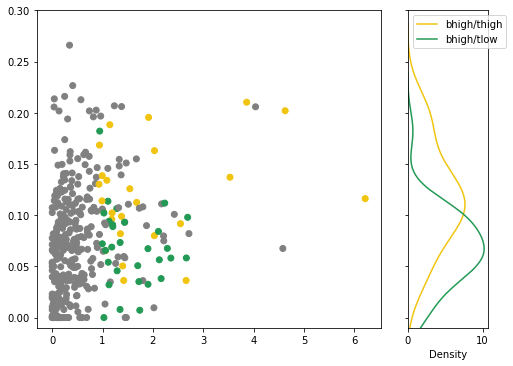

In [73]:
# H
plot_tfh_distribution("TERT",savefig = False, hpv_negative_only = True)

SpearmanrResult(correlation=0.26673671655072967, pvalue=1.5765377296984892e-07)
Ttest_indResult(statistic=1.5724214535046763, pvalue=0.12270657307918022)


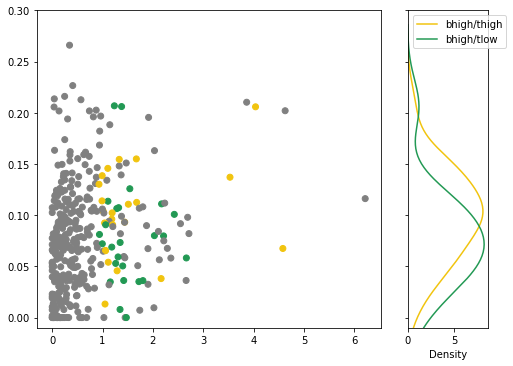

In [74]:
# I
plot_tfh_distribution("MUC1",savefig = False, hpv_negative_only = True)